In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import os
import math
import random
import pyarrow.parquet as pq
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
def is_parquet_file(filename):
    return (filename[0].endswith(".parquet"))

class LandmarkDataset(Dataset):
    def __init__(self, data, labels):
        
        
        self.labels = torch.LongTensor(labels).to(device)
        self.landmark_filenames = ['/kaggle/input/iasl-dataset/'+x[0] for x in data if is_parquet_file(x)]
        self.data = [torch.FloatTensor(pd.read_parquet(path).values).to(device) for path in tqdm(self.landmark_filenames,desc='Loading data', total=len(self.landmark_filenames))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        
        return self.data[idx], self.labels[idx]

In [4]:
data = pd.read_csv("/kaggle/input/final-train/final_train.csv")
data = data.drop(["Unnamed: 0"], axis = 1)

In [5]:
X = data["path"].values
X = X.reshape(-1,1)
X

array([['dataset4/asl-signs/train_landmark_files/26734/1000035562.parquet'],
       ['dataset4/asl-signs/train_landmark_files/28656/1000106739.parquet'],
       ['dataset4/asl-signs/train_landmark_files/16069/100015657.parquet'],
       ...,
       ['dataset4/asl-signs/train_landmark_files/25571/999833418.parquet'],
       ['dataset4/asl-signs/train_landmark_files/29302/999895257.parquet'],
       ['dataset4/asl-signs/train_landmark_files/36257/999962374.parquet']],
      dtype=object)

In [6]:
Y = data["label"].values
#Y = Y.reshape(-1,1)
Y

array([ 25, 232,  48, ...,  86, 188, 105])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [8]:
print("X shape: ",X.shape)
print("Y shape: ",Y.shape)
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X shape:  (94477, 1)
Y shape:  (94477,)
X_train shape:  (85029, 1)
y_train shape:  (85029,)
X_test shape:  (9448, 1)
y_test shape:  (9448,)


In [9]:
train_dataset = LandmarkDataset(X_train, y_train)
val_dataset = LandmarkDataset(X_test, y_test)

Loading data: 100%|██████████| 9448/9448 [05:21<00:00, 29.40it/s]


In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)#, num_workers=8, drop_last=False, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)#, num_workers=8, drop_last=False, pin_memory=True)

In [11]:
class GRUModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, bidirectional, num_classes, batch_first, dropout):
        super(GRUModel,self).__init__()
        self.num_fearturs = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_classes = num_classes
        self.batch_first = batch_first
        self.gru = nn.GRU(input_size = num_features, hidden_size = hidden_size, num_layers = num_layers, batch_first = batch_first, bidirectional = bidirectional, dropout = dropout)
        if self.bidirectional:
            self.fc = nn.Linear(hidden_size*2, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        self.embed = nn.Sequential(
            nn.Linear(num_features, num_features*2, bias = True),
            nn.LayerNorm(num_features*2),
            nn.ReLU(inplace = True),
            nn.Linear(num_features*2, num_features, bias = True),
            nn.LayerNorm(num_features),
            nn.ReLU(inplace = True)
            )
        
    def forward(self, x):
        x = self.embed(x)
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers*2, x.shape[0], self.hidden_size).to(x.device)
            
        else:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

In [44]:
import optuna
from optuna.pruners import MedianPruner

def train(params,save_model, trial):
    learning_rate = 5e-4
    weight_decay = 1e-1
    cycle = 8
    model = RNNModel(num_features = 176, hidden_size = params["hidden_size"], num_layers = params['num_layers'], 
                  bidirectional = params["bidirectional"], num_classes = 250, batch_first = True, dropout = params['dropout']).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cycle, eta_min=learning_rate / 10)
    best_loss = float('inf')
    saved_state = model.state_dict()

    epochs = 10
    for epoch in range(epochs):
        acc, loss, v_acc, v_loss = 0,0,0,0
        
        total_batches = len(train_loader)
        train_size, train_batches = 0, 0
        train_loss, train_correct = 0, 0
        val_size, val_batches = 0, 0
        val_loss, val_correct = 0, 0
        n_offset=1

        with tqdm(desc=f'Epoch {epoch+n_offset}', total=total_batches) as bar:

            # Training
            for batch, (src, y) in enumerate(train_loader):

                # Compute prediction and loss
                pred = model(src)
                loss = loss_fn(pred, y)

                # Compute metrics
                train_loss += loss.item()
                train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                train_size += len(y)
                train_batches += 1

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()

                scheduler.step(epoch + batch / total_batches)

                # Update progress bar
                bar.update()
                bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches,
                               lr=scheduler.get_last_lr())

            bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches)
            #scheduler.step()

            # Validation
            with torch.no_grad():

                for batch, (src, y) in enumerate(val_loader):

                    # Compute prediction and loss
                    pred = model(src)
                    val_loss += loss_fn(pred, y).item()

                    # Compute metrics
                    val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    val_size += len(y)
                    val_batches += 1

                    # Update progress bar
                    bar.set_postfix(
                        accuracy = train_correct / train_size, loss = train_loss / train_batches,
                        val_accuracy = val_correct / val_size, val_loss = val_loss / val_batches
                    )
                    
            

        if scheduler.T_0 - scheduler.T_cur < 0.1:
            print()
        acc = train_correct / train_size
        loss = train_loss / train_batches
        v_acc = val_correct / val_size
        v_loss = val_loss / val_batches
        
        
        if v_loss<best_loss:
            best_loss = v_loss
            if save_model:
                saved_state = model.state_dict()
        
        if trial.should_prune():
                raise optuna.TrialPruned()
                
        
            
    return best_loss

def objective(trial):
    params = {
        "hidden_size": trial.suggest_categorical("hidden_size",[64,96,128,180, 256]),
        "num_layers" : trial.suggest_int("num_layers",1,8),
        "bidirectional": trial.suggest_categorical("bidirectional",[True, False]),
        "dropout": trial.suggest_float("dropout",0.1,0.7)
    }
    print(trial.params)
    best_val_loss = train(params, False, trial)
    return best_val_loss

study = optuna.create_study(direction = "minimize", pruner=MedianPruner())
study.optimize(objective, n_trials = 20)


[I 2023-04-28 06:37:54,357] A new study created in memory with name: no-name-546ac466-744b-47f9-ba72-4272dd35a500
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:70: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2600146496338062 and num_layers=1



{'hidden_size': 128, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.2600146496338062}


Epoch 8: 100%|██████████| 665/665 [00:14<00:00, 45.33it/s, accuracy=0.0338, loss=4.76, val_accuracy=0.0375, val_loss=4.74]


Epoch 10: 100%|██████████| 665/665 [00:14<00:00, 44.99it/s, accuracy=0.0439, loss=4.65, val_accuracy=0.0466, val_loss=4.61]
[I 2023-04-28 06:40:22,677] Trial 0 finished with value: 4.607485519873129 and parameters: {'hidden_size': 128, 'num_layers': 1, 'bidirectional': True, 'dropout': 0.2600146496338062}. Best is trial 0 with value: 4.607485519873129.


{'hidden_size': 128, 'num_layers': 4, 'bidirectional': True, 'dropout': 0.21151258161296177}


Epoch 8: 100%|██████████| 665/665 [00:58<00:00, 11.38it/s, accuracy=0.0502, loss=4.63, val_accuracy=0.0543, val_loss=4.61]


Epoch 10: 100%|██████████| 665/665 [00:58<00:00, 11.38it/s, accuracy=0.0628, loss=4.52, val_accuracy=0.0759, val_loss=4.4] 
[I 2023-04-28 06:50:07,803] Trial 1 finished with value: 4.398430160574011 and parameters: {'hidden_size': 128, 'num_layers': 4, 'bidirectional': True, 'dropout': 0.21151258161296177}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 64, 'num_layers': 2, 'bidirectional': False, 'dropout': 0.18824719412604152}


Epoch 8: 100%|██████████| 665/665 [00:12<00:00, 52.18it/s, accuracy=0.016, loss=5.08, val_accuracy=0.0171, val_loss=5.06]


Epoch 10: 100%|██████████| 665/665 [00:13<00:00, 50.07it/s, accuracy=0.0193, loss=5.02, val_accuracy=0.0235, val_loss=4.95]
[I 2023-04-28 06:52:18,127] Trial 2 finished with value: 4.95441063030346 and parameters: {'hidden_size': 64, 'num_layers': 2, 'bidirectional': False, 'dropout': 0.18824719412604152}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 256, 'num_layers': 3, 'bidirectional': False, 'dropout': 0.11504825614734288}


Epoch 8: 100%|██████████| 665/665 [00:30<00:00, 21.59it/s, accuracy=0.0051, loss=5.51, val_accuracy=0.00519, val_loss=5.51]


Epoch 10: 100%|██████████| 665/665 [00:30<00:00, 21.58it/s, accuracy=0.0064, loss=5.49, val_accuracy=0.0091, val_loss=5.46] 
[I 2023-04-28 06:57:26,434] Trial 3 finished with value: 5.455917822348105 and parameters: {'hidden_size': 256, 'num_layers': 3, 'bidirectional': False, 'dropout': 0.11504825614734288}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 128, 'num_layers': 2, 'bidirectional': False, 'dropout': 0.1876097736696587}


Epoch 8: 100%|██████████| 665/665 [00:16<00:00, 40.76it/s, accuracy=0.0177, loss=5.05, val_accuracy=0.0164, val_loss=5.05]


Epoch 10: 100%|██████████| 665/665 [00:16<00:00, 40.61it/s, accuracy=0.0254, loss=4.9, val_accuracy=0.0279, val_loss=4.88]
[I 2023-04-28 07:00:08,315] Trial 4 finished with value: 4.878598155202092 and parameters: {'hidden_size': 128, 'num_layers': 2, 'bidirectional': False, 'dropout': 0.1876097736696587}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 128, 'num_layers': 8, 'bidirectional': False, 'dropout': 0.25995484843757766}


Epoch 8: 100%|██████████| 665/665 [00:45<00:00, 14.48it/s, accuracy=0.0406, loss=4.73, val_accuracy=0.0377, val_loss=4.73]


Epoch 10: 100%|██████████| 665/665 [00:46<00:00, 14.41it/s, accuracy=0.0478, loss=4.65, val_accuracy=0.0496, val_loss=4.64]
[I 2023-04-28 07:07:49,587] Trial 5 finished with value: 4.639773961660024 and parameters: {'hidden_size': 128, 'num_layers': 8, 'bidirectional': False, 'dropout': 0.25995484843757766}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 64, 'num_layers': 7, 'bidirectional': False, 'dropout': 0.533122580307897}


Epoch 8: 100%|██████████| 665/665 [00:34<00:00, 19.28it/s, accuracy=0.0248, loss=4.92, val_accuracy=0.0269, val_loss=4.9] 


Epoch 10: 100%|██████████| 665/665 [00:34<00:00, 19.30it/s, accuracy=0.0322, loss=4.78, val_accuracy=0.0308, val_loss=4.79]
[I 2023-04-28 07:13:35,143] Trial 6 finished with value: 4.793517654006545 and parameters: {'hidden_size': 64, 'num_layers': 7, 'bidirectional': False, 'dropout': 0.533122580307897}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 96, 'num_layers': 2, 'bidirectional': True, 'dropout': 0.42405479385014255}


Epoch 8: 100%|██████████| 665/665 [00:24<00:00, 27.19it/s, accuracy=0.0294, loss=4.85, val_accuracy=0.0323, val_loss=4.83]


Epoch 10: 100%|██████████| 665/665 [00:24<00:00, 27.36it/s, accuracy=0.0387, loss=4.7, val_accuracy=0.0425, val_loss=4.69] 
[I 2023-04-28 07:17:38,384] Trial 7 finished with value: 4.6940127772253915 and parameters: {'hidden_size': 96, 'num_layers': 2, 'bidirectional': True, 'dropout': 0.42405479385014255}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 96, 'num_layers': 7, 'bidirectional': False, 'dropout': 0.3360486242054846}


Epoch 8: 100%|██████████| 665/665 [00:35<00:00, 18.57it/s, accuracy=0.0388, loss=4.76, val_accuracy=0.0453, val_loss=4.75]


Epoch 10: 100%|██████████| 665/665 [00:35<00:00, 18.65it/s, accuracy=0.0412, loss=4.71, val_accuracy=0.0397, val_loss=4.73]
[I 2023-04-28 07:23:37,350] Trial 8 finished with value: 4.733297135378863 and parameters: {'hidden_size': 96, 'num_layers': 7, 'bidirectional': False, 'dropout': 0.3360486242054846}. Best is trial 1 with value: 4.398430160574011.
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:70: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3439272437515305 and num_layers=1



{'hidden_size': 128, 'num_layers': 1, 'bidirectional': False, 'dropout': 0.3439272437515305}


Epoch 8: 100%|██████████| 665/665 [00:11<00:00, 55.56it/s, accuracy=0.0225, loss=4.97, val_accuracy=0.0218, val_loss=4.97]


Epoch 10: 100%|██████████| 665/665 [00:12<00:00, 54.35it/s, accuracy=0.0291, loss=4.83, val_accuracy=0.0358, val_loss=4.72]
[I 2023-04-28 07:25:38,187] Trial 9 finished with value: 4.718760129567739 and parameters: {'hidden_size': 128, 'num_layers': 1, 'bidirectional': False, 'dropout': 0.3439272437515305}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 180, 'num_layers': 5, 'bidirectional': True, 'dropout': 0.6608122561997859}


Epoch 8: 100%|██████████| 665/665 [01:36<00:00,  6.86it/s, accuracy=0.00496, loss=5.52, val_accuracy=0.00392, val_loss=5.52]


Epoch 10: 100%|██████████| 665/665 [01:36<00:00,  6.87it/s, accuracy=0.00457, loss=5.52, val_accuracy=0.00593, val_loss=5.52]
[I 2023-04-28 07:41:46,156] Trial 10 finished with value: 5.521273438994949 and parameters: {'hidden_size': 180, 'num_layers': 5, 'bidirectional': True, 'dropout': 0.6608122561997859}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 128, 'num_layers': 4, 'bidirectional': True, 'dropout': 0.2553022319782813}


Epoch 8: 100%|██████████| 665/665 [00:58<00:00, 11.36it/s, accuracy=0.0464, loss=4.66, val_accuracy=0.0468, val_loss=4.64]


Epoch 10: 100%|██████████| 665/665 [00:58<00:00, 11.39it/s, accuracy=0.0585, loss=4.55, val_accuracy=0.0751, val_loss=4.4] 
[I 2023-04-28 07:51:30,738] Trial 11 finished with value: 4.399130988765407 and parameters: {'hidden_size': 128, 'num_layers': 4, 'bidirectional': True, 'dropout': 0.2553022319782813}. Best is trial 1 with value: 4.398430160574011.


{'hidden_size': 128, 'num_layers': 5, 'bidirectional': True, 'dropout': 0.10342173624073037}


Epoch 8: 100%|██████████| 665/665 [01:13<00:00,  9.01it/s, accuracy=0.0706, loss=4.46, val_accuracy=0.0711, val_loss=4.45]


Epoch 10: 100%|██████████| 665/665 [01:14<00:00,  8.95it/s, accuracy=0.0856, loss=4.32, val_accuracy=0.0999, val_loss=4.24]
[I 2023-04-28 08:03:50,255] Trial 12 finished with value: 4.237447835303642 and parameters: {'hidden_size': 128, 'num_layers': 5, 'bidirectional': True, 'dropout': 0.10342173624073037}. Best is trial 12 with value: 4.237447835303642.


{'hidden_size': 256, 'num_layers': 5, 'bidirectional': True, 'dropout': 0.11497753327173277}


Epoch 8: 100%|██████████| 665/665 [02:15<00:00,  4.92it/s, accuracy=0.0233, loss=4.96, val_accuracy=0.0271, val_loss=4.95] 


Epoch 10: 100%|██████████| 665/665 [02:15<00:00,  4.92it/s, accuracy=0.0344, loss=4.82, val_accuracy=0.0421, val_loss=4.76]
[I 2023-04-28 08:26:27,690] Trial 13 finished with value: 4.75723850404894 and parameters: {'hidden_size': 256, 'num_layers': 5, 'bidirectional': True, 'dropout': 0.11497753327173277}. Best is trial 12 with value: 4.237447835303642.


{'hidden_size': 180, 'num_layers': 6, 'bidirectional': True, 'dropout': 0.10843438713051433}


Epoch 8: 100%|██████████| 665/665 [01:56<00:00,  5.69it/s, accuracy=0.0646, loss=4.5, val_accuracy=0.0676, val_loss=4.49]


Epoch 10: 100%|██████████| 665/665 [01:56<00:00,  5.73it/s, accuracy=0.0733, loss=4.42, val_accuracy=0.0941, val_loss=4.28]
[I 2023-04-28 08:45:51,660] Trial 14 finished with value: 4.284502338718724 and parameters: {'hidden_size': 180, 'num_layers': 6, 'bidirectional': True, 'dropout': 0.10843438713051433}. Best is trial 12 with value: 4.237447835303642.


{'hidden_size': 180, 'num_layers': 6, 'bidirectional': True, 'dropout': 0.1192279386651481}


Epoch 8: 100%|██████████| 665/665 [01:56<00:00,  5.73it/s, accuracy=0.0498, loss=4.65, val_accuracy=0.0529, val_loss=4.63]


Epoch 10: 100%|██████████| 665/665 [01:56<00:00,  5.72it/s, accuracy=0.0639, loss=4.52, val_accuracy=0.083, val_loss=4.42] 
[I 2023-04-28 09:05:14,724] Trial 15 finished with value: 4.422330424592301 and parameters: {'hidden_size': 180, 'num_layers': 6, 'bidirectional': True, 'dropout': 0.1192279386651481}. Best is trial 12 with value: 4.237447835303642.


{'hidden_size': 180, 'num_layers': 6, 'bidirectional': True, 'dropout': 0.10001776907345944}


Epoch 8: 100%|██████████| 665/665 [01:56<00:00,  5.72it/s, accuracy=0.0135, loss=5.18, val_accuracy=0.014, val_loss=5.13]  


Epoch 10: 100%|██████████| 665/665 [01:56<00:00,  5.71it/s, accuracy=0.0158, loss=5.09, val_accuracy=0.0177, val_loss=5.05]
[I 2023-04-28 09:24:35,869] Trial 16 finished with value: 5.0463211987469645 and parameters: {'hidden_size': 180, 'num_layers': 6, 'bidirectional': True, 'dropout': 0.10001776907345944}. Best is trial 12 with value: 4.237447835303642.


{'hidden_size': 180, 'num_layers': 6, 'bidirectional': True, 'dropout': 0.1756552716851581}


Epoch 8: 100%|██████████| 665/665 [01:56<00:00,  5.72it/s, accuracy=0.0432, loss=4.68, val_accuracy=0.0458, val_loss=4.67]


Epoch 10: 100%|██████████| 665/665 [01:56<00:00,  5.70it/s, accuracy=0.0579, loss=4.57, val_accuracy=0.0693, val_loss=4.48]
[I 2023-04-28 09:43:58,052] Trial 17 finished with value: 4.484471327549702 and parameters: {'hidden_size': 180, 'num_layers': 6, 'bidirectional': True, 'dropout': 0.1756552716851581}. Best is trial 12 with value: 4.237447835303642.


{'hidden_size': 180, 'num_layers': 8, 'bidirectional': True, 'dropout': 0.16666633570419814}


Epoch 8: 100%|██████████| 665/665 [02:35<00:00,  4.27it/s, accuracy=0.00485, loss=5.52, val_accuracy=0.00381, val_loss=5.52]


Epoch 10: 100%|██████████| 665/665 [02:36<00:00,  4.25it/s, accuracy=0.00427, loss=5.52, val_accuracy=0.0037, val_loss=5.52] 
[I 2023-04-28 10:09:56,763] Trial 18 finished with value: 5.521262613502708 and parameters: {'hidden_size': 180, 'num_layers': 8, 'bidirectional': True, 'dropout': 0.16666633570419814}. Best is trial 12 with value: 4.237447835303642.


{'hidden_size': 64, 'num_layers': 5, 'bidirectional': True, 'dropout': 0.33755950065527396}


Epoch 8: 100%|██████████| 665/665 [00:51<00:00, 12.96it/s, accuracy=0.0239, loss=4.95, val_accuracy=0.0237, val_loss=4.94]


Epoch 10: 100%|██████████| 665/665 [00:50<00:00, 13.06it/s, accuracy=0.0359, loss=4.74, val_accuracy=0.036, val_loss=4.72]  
[I 2023-04-28 10:18:27,561] Trial 19 finished with value: 4.7164601699726 and parameters: {'hidden_size': 64, 'num_layers': 5, 'bidirectional': True, 'dropout': 0.33755950065527396}. Best is trial 12 with value: 4.237447835303642.


In [46]:
from optuna.trial import TrialState

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))


print("Best trial:")
trial_ = study.best_trial

print("  Value: ", trial_.value)

print("  Params: ")
for key, value in trial_.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  4.237447835303642
  Params: 
    hidden_size: 128
    num_layers: 5
    bidirectional: True
    dropout: 0.10342173624073037


In [47]:
# Visualize the optimization history.
from optuna.visualization import plot_contour
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
plot_optimization_history(study).show()

In [48]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study).show()

In [49]:
plot_contour(study).show()

In [50]:
# Visualize individual hyperparameters.
plot_slice(study).show()

In [51]:
# Visualize parameter importances.
plot_param_importances(study).show()

# Training

In [14]:
num_features = 176
hidden_size = 128
num_layers = 5
num_classes = 250
model = GRUModel(num_features = num_features, hidden_size = hidden_size, num_layers = num_layers, 
                  bidirectional = True, num_classes = num_classes, batch_first = True, dropout = 0.10342173624073037).to(device)

In [15]:
learning_rate = 5e-4
weight_decay = 1e-1
cycle = 8

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cycle, eta_min=learning_rate / 10)

train_losses = []
val_losses = []

def train_val_loop(epoch, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler, n_offset=1):
    total_batches = len(train_dataloader)
    train_size, train_batches = 0, 0
    train_loss, train_correct = 0, 0
    val_size, val_batches = 0, 0
    val_loss, val_correct = 0, 0
    
    with tqdm(desc=f'Epoch {epoch+n_offset}', total=total_batches) as bar:
        
        # Training
        for batch, (src, y) in enumerate(train_dataloader):
            
            # Compute prediction and loss
            pred = model(src)
            loss = loss_fn(pred, y)
            
            # Compute metrics
            train_loss += loss.item()
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_size += len(y)
            train_batches += 1

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
                
            scheduler.step(epoch + batch / total_batches)
            
            # Update progress bar
            bar.update()
            bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches,
                           lr=scheduler.get_last_lr())
            
        bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches)
        
        #scheduler.step()
           
        # Validation
        with torch.no_grad():

            for batch, (src, y) in enumerate(val_dataloader):
                
                # Compute prediction and loss
                pred = model(src)
                val_loss += loss_fn(pred, y).item()
                
                # Compute metrics
                val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                val_size += len(y)
                val_batches += 1

                # Update progress bar
                bar.set_postfix(
                    accuracy = train_correct / train_size, loss = train_loss / train_batches,
                    val_accuracy = val_correct / val_size, val_loss = val_loss / val_batches
                )
                
    if scheduler.T_0 - scheduler.T_cur < 0.1:
        print()
        
    train_losses.append(train_loss / train_batches)
    val_losses.append(val_loss / val_batches)

    return train_correct / train_size, train_loss / train_batches, val_correct / val_size, val_loss / val_batches


best_loss = float('inf')
saved_state = model.state_dict()

epochs = 300


#model.load_state_dict(torch.load("/kaggle/input/lstm-model/lstm_model_100Epochs_ss.pth"))
# Iterate through epochs for training
for epoch in range(epochs):
    
    acc, loss, v_acc, v_loss = train_val_loop(epoch, train_loader, val_loader, model, loss_fn, optimizer, scheduler)
    
    if v_loss<best_loss:
        best_loss = v_loss
        saved_state = model.state_dict()
    if (epoch + 1)  == 200 or (epoch + 1)  == 240:
        torch.save(model.state_dict(), 'GRUmodel.pth')
        torch.save(saved_state,'BestGru.pth')

Epoch 8: 100%|██████████| 665/665 [01:14<00:00,  8.89it/s, accuracy=0.0531, loss=4.6, val_accuracy=0.0582, val_loss=4.59]


Epoch 16: 100%|██████████| 665/665 [01:14<00:00,  8.91it/s, accuracy=0.194, loss=3.66, val_accuracy=0.196, val_loss=3.7] 


Epoch 24: 100%|██████████| 665/665 [01:14<00:00,  8.96it/s, accuracy=0.446, loss=2.41, val_accuracy=0.424, val_loss=2.53]


Epoch 32: 100%|██████████| 665/665 [01:14<00:00,  8.89it/s, accuracy=0.568, loss=1.85, val_accuracy=0.515, val_loss=2.08]


Epoch 40: 100%|██████████| 665/665 [01:15<00:00,  8.86it/s, accuracy=0.646, loss=1.51, val_accuracy=0.571, val_loss=1.84]


Epoch 48: 100%|██████████| 665/665 [01:14<00:00,  8.92it/s, accuracy=0.698, loss=1.3, val_accuracy=0.593, val_loss=1.75]


Epoch 56: 100%|██████████| 665/665 [01:14<00:00,  8.91it/s, accuracy=0.736, loss=1.15, val_accuracy=0.612, val_loss=1.67]


Epoch 64: 100%|██████████| 665/665 [01:14<00:00,  8.91it/s, accuracy=0.767, loss=1.03, val_accuracy=0.618, val_loss=1.64]


Epoch 72: 100%|██████████| 665/665 [01:14<00:00,  8.91it/s, accuracy=0.792, loss=0.926, val_accuracy=0.632, val_loss=1.6] 


Epoch 80: 100%|██████████| 665/665 [01:14<00:00,  8.93it/s, accuracy=0.813, loss=0.845, val_accuracy=0.638, val_loss=1.6] 


Epoch 88: 100%|██████████| 665/665 [01:14<00:00,  8.92it/s, accuracy=0.83, loss=0.779, val_accuracy=0.636, val_loss=1.6] 


Epoch 96: 100%|██████████| 665/665 [01:13<00:00,  8.99it/s, accuracy=0.845, loss=0.723, val_accuracy=0.64, val_loss=1.6]  


Epoch 104: 100%|██████████| 665/665 [01:14<00:00,  8.88it/s, accuracy=0.857, loss=0.676, val_accuracy=0.636, val_loss=1.62]


Epoch 112: 100%|██████████| 665/665 [01:13<00:00,  9.00it/s, accuracy=0.867, loss=0.638, val_accuracy=0.644, val_loss=1.6] 


Epoch 120: 100%|██████████| 665/665 [01:14<00:00,  8.91it/s, accuracy=0.876, loss=0.606, val_accuracy=0.645, val_loss=1.61]


Epoch 128: 100%|██████████| 665/665 [01:14<00:00,  8.93it/s, accuracy=0.883, loss=0.576, val_accuracy=0.649, val_loss=1.61]


Epoch 136: 100%|██████████| 665/665 [01:15<00:00,  8.85it/s, accuracy=0.889, loss=0.551, val_accuracy=0.636, val_loss=1.66]


Epoch 140:  28%|██▊       | 184/665 [00:20<00:52,  9.17it/s, accuracy=0.808, loss=0.805, lr=[0.000338181182241803]]  


KeyboardInterrupt: 

In [16]:
torch.save(model.state_dict(),"GRUFinalModel.pth")
torch.save(saved_state,"GRUBestModelFinal.pth")

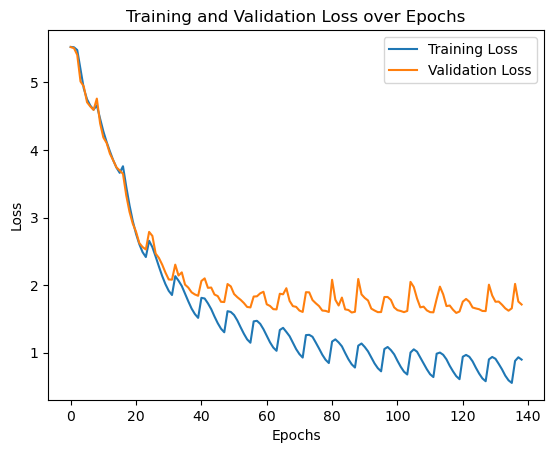

In [17]:
# Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [18]:
print(f"Testing the Best Model on Validation Set: ")

test_loss = 0.0
test_acc = 0.0

num_features = 176
hidden_size = 128
num_layers = 5
num_classes = 250
model = GRUModel(num_features = num_features, hidden_size = hidden_size, num_layers = num_layers, 
                  bidirectional = True, num_classes = num_classes, batch_first = True, dropout = 0.10342173624073037).to(device)
model.load_state_dict(saved_state)
loss_fn = nn.CrossEntropyLoss()

with torch.no_grad():
    
    for data, labels in val_loader:
        outputs = model(data)
        loss = loss_fn(outputs, labels)
        test_loss +=loss.item()
        _,gt = torch.max(outputs,1)
        test_acc += torch.sum(labels==gt)

    test_loss = test_loss/(len(val_loader)*128)
    test_acc = test_acc/(len(val_loader)*128)


    print(f'\tTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Testing the Best Model on Validation Set: 
	Test Loss: 0.0148, Test Accuracy: 0.5802


In [19]:
def get_mean_classification_accuracy(dataloader):
    
    acc=[]
    with torch.no_grad():
        
        batch = 0
        mean_acc = 0.0
        for data, labels in dataloader:
            
            correct_preds = 0
            total_preds = 0
            
            batch = batch + 1
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs,1)
            correct_preds = correct_preds + torch.sum(preds==labels.data)
            total_preds = labels.size(0)
            acc.append(correct_preds/total_preds)
        mean_acc = torch.mean(torch.tensor(acc))
        return mean_acc
mean_acc_on_val_set = get_mean_classification_accuracy(val_loader)
mean_acc_on_train_set = get_mean_classification_accuracy(train_loader)

print(f'Mean Classification Accuracy on Train Set: {100*mean_acc_on_train_set:.4f}')
print(f'Mean Classification Accuracy on Validation Set: {100*mean_acc_on_val_set:.4f}')

Mean Classification Accuracy on Train Set: 76.6774
Mean Classification Accuracy on Validation Set: 58.2064


In [21]:
def get_mean_per_class_accuracy(dataloader):
    with torch.no_grad():
        class_acc = [[] for i in range(250)]
        
        num_classes = 250
        class_correct = [0] * num_classes
        class_total = [0] * num_classes
        for data, labels in dataloader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            for i in range(num_classes):
                if class_total[i]==0:
                    class_acc[i].append(0)
                else:
                    class_acc[i].append(class_correct[i]/class_total[i])
        mean_per_class_acc_list = [torch.mean(torch.tensor(class_acc[i])) for i in range(len(class_acc))]
        return mean_per_class_acc_list
    
import json
def read_json(path):
    with open(path, "r") as file:
        json_data = json.load(file)
    return json_data

s2p_map = read_json(os.path.join("/kaggle/input/json-data/sign_to_prediction_index_map.json"))
p2s_map = {v: k for k, v in s2p_map.items()}

encoder = lambda x: s2p_map.get(x)
decoder = lambda x: p2s_map.get(x)


print('Mean per class accuracies for the train set: ')
train_mean_per_class_acc = get_mean_per_class_accuracy(train_loader)
for i in range(len(train_mean_per_class_acc)):
    print(f'{p2s_map[i]}: {100*train_mean_per_class_acc[i]:.4f}')
    
print('Mean per class accuracies for the validation set: ')
val_mean_per_class_acc = get_mean_per_class_accuracy(val_loader)
for i in range(len(val_mean_per_class_acc)):
    print(f'{p2s_map[i]}: {100*val_mean_per_class_acc[i]:.4f}')

Mean per class accuracies for the train set: 
TV: 82.7400
after: 67.5341
airplane: 80.9252
all: 73.2297
alligator: 85.8583
animal: 65.8399
another: 72.6171
any: 80.0514
apple: 79.5291
arm: 79.5033
aunt: 87.2688
awake: 64.1937
backyard: 76.4954
bad: 69.1559
balloon: 76.9211
bath: 82.9183
because: 86.6606
bed: 78.9134
bedroom: 75.1995
bee: 86.3381
before: 72.7100
beside: 56.2097
better: 83.1829
bird: 87.1697
black: 88.6096
blow: 83.7309
blue: 68.2881
boat: 75.8601
book: 69.4004
boy: 78.6291
brother: 80.9729
brown: 91.0268
bug: 89.7156
bye: 82.5484
callonphone: 85.4423
can: 82.9018
car: 73.6150
carrot: 85.1166
cat: 71.8665
cereal: 82.1505
chair: 59.1159
cheek: 83.8482
child: 59.2536
chin: 62.7515
chocolate: 83.7790
clean: 74.4957
close: 67.8753
closet: 80.4729
cloud: 73.9818
clown: 93.4131
cow: 88.6893
cowboy: 74.5055
cry: 74.4271
cut: 74.5878
cute: 75.0136
dad: 82.2203
dance: 54.8989
dirty: 71.8822
dog: 67.2727
doll: 88.1398
donkey: 69.2223
down: 71.0765
drawer: 81.5236
drink: 83.6441
dr

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [v for k,v in p2s_map.items()],
                     columns = [v for k,v in p2s_map.items()])
plt.figure(figsize = (250,250))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')